In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import matplotlib.lines as mlines
import re
from collections import Counter

In [2]:
df = pd.read_csv("../../1_annotation_tools/data/datasets_to_check/combined_datasets/combined_datasets.csv").fillna("")

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [4]:
def normalize_book(name: str) -> str:
    if any(name.startswith(prefix) for prefix in ["1_Samuel", "2_Samuel"]):
        return "Samuel"
    elif any(name.startswith(prefix) for prefix in ["1_Kings", "2_Kings"]):
        return "Kings"
    elif any(name.startswith(prefix) for prefix in ["1_Chronicles", "2_Chronicles"]):
        return "Chronicles"
    else:
        return name

df["book2"] = df["book"].apply(normalize_book)

In [5]:
# Create a book_scroll column
df['book_scroll'] = df['book2'] + "_" + df['scroll']

In [6]:
#set(df.book_scroll)

In [7]:
#set(df.book2)

In [8]:
set(df.cmpl_constr)

{'', 'dir-he', 'prep', 'prep + dir-he', 'vc'}

In [9]:
exclude_comments = ["min excluded", "reconstructed", "verb rec"]
motion_type = ["factive", "fictive"]

df_goals = df[~df['comments'].isin(exclude_comments)].copy()
df_goals = df_goals[df_goals['spatial_arg_type'] == "goal"].copy()
df_goals = df_goals[df_goals['motion_type'].isin(motion_type)].copy()

In [10]:
df_goals['cmpl_constr'] = df_goals['cmpl_constr'].replace("vc", "unmarked")

In [11]:
print(set(df_goals.motion_type))
print(set(df_goals.spatial_arg_type))
print(set(df_goals.cmpl_constr))

{'factive', 'fictive'}
{'goal'}
{'prep', 'unmarked', 'dir-he', 'prep + dir-he'}


In [12]:
#set(df_goals.comments)

## Part 1: select an example dataframe

In [13]:
# Overall counts
lex_counts = df_goals['lex'].value_counts().reset_index()
lex_counts.columns = ['lex', 'count']

# Show top 10
print(lex_counts.head(10))

    lex  count
0  BW>[   1734
1  <LH[    411
2  CWB[    403
3  HLK[    362
4  JY>[    236
5  JRD[    198
6  QRB[    163
7  <BR[    102
8  NGC[     73
9  NWS[     48


In [14]:
# Overall counts
constr_counts = df_goals['cmpl_constr'].value_counts().reset_index()
constr_counts.columns = ['cmpl_constr', 'count']

# Show top 10
print(constr_counts.head(10))

     cmpl_constr  count
0           prep   2966
1       unmarked    619
2         dir-he    413
3  prep + dir-he      7


In [15]:
#Counter(df_goals.cmpl_lex[(df_goals.lex == "<LH[") & (df_goals.cmpl_constr == "prep")])

In [16]:
# Save the 5 most frequent verbs in a list
freq_verbs = lex_counts.head(5)['lex'].to_list()

In [17]:
# Filter a dataframe with only the 5 most frequent verbs
df_top5 = df_goals[df_goals['lex'].isin(freq_verbs)]

In [18]:
# Select books for example

# Count total occurrences of all top5 verbs per book_scroll
book_totals = (
    df_top5.groupby('book_scroll')
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)

# Take the top 20
top20_books = book_totals.head(20)

print(top20_books)

        book_scroll  count
112       Samuel_MT    376
79         Kings_MT    320
55       Genesis_MT    261
5     Chronicles_MT    255
66      Jeremiah_MT    248
49       Ezekiel_MT    158
76        Judges_MT    139
42        Exodus_MT    135
24   Deuteronomy_MT    130
75        Joshua_MT    124
96       Numbers_MT    124
61    Isaiah_1Qisaa     96
62        Isaiah_MT     95
85     Leviticus_MT     81
103       Psalms_MT     73
67           Job_MT     39
93      Nehemiah_MT     33
28        Esther_MT     30
6         Daniel_MT     27
1           1QM_1QM     24


In [19]:
# Select one Qumran sectarian scroll for example
qumran_scrolls = ["1QH_1QH", "1QM_1QM", "1QS_1QS"]

qumran_counts = (
    df_top5[df_top5['book_scroll'].isin(qumran_scrolls)]
    .groupby('book_scroll')
    .size()
    .reset_index(name='count')
)

print(qumran_counts)

  book_scroll  count
0     1QH_1QH     11
1     1QM_1QM     24
2     1QS_1QS     19


## Part 2: Visualize goal markings in the different books - Selected Books

In [20]:
# 1) Aggregate & normalize (exclude "prep + dir-he")
dfx = (
    df_top5.loc[df_top5["cmpl_constr"].ne("prep + dir-he")]
    .dropna(subset=["lex","book_scroll","cmpl_constr"])
)

In [21]:
# Example mapping (fill in with your real Hebrew forms)
lex_to_hebrew = {
    "BW>[": "בּוא",
    "<LH[": "עלה",
    "CWB[": "שׁוב",
    "HLK[": "הלך",
    "JY>[": "יצא",
    # add more as needed...
}

In [41]:
len(set(dfx.book_scroll))

118

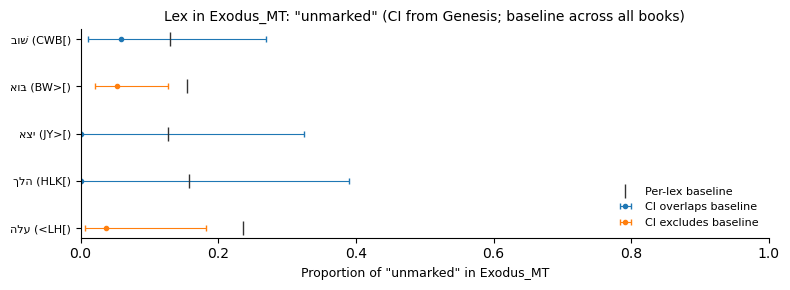

In [38]:
# -------------------- config --------------------
BOOK_NAME = "Exodus_MT"   # the book to focus on
BOOK_COL_CANDIDATES = ["book_scroll"]  # pick whichever exists
construction = "unmarked"  # e.g., "dir-he" or "prep"
MIN_N = 5                # minimum # of tokens (this lex) in Genesis to include
Z = 1.96                 # 95% Wilson intervals
ROW_HEIGHT = 0.20        # smaller => tighter rows
SAVE_FIG = False         # set True to save
SAVE_PATH = f"plot_forest_lex_in_{BOOK_NAME}_{construction}.png"

# -------------------- choose the book column --------------------
for _col in BOOK_COL_CANDIDATES:
    if _col in dfx.columns:
        BOOK_COL = _col
        break
else:
    raise ValueError(f"None of {BOOK_COL_CANDIDATES} found in dfx columns.")

# -------------------- data prep --------------------
# Genesis slice
df_gen = dfx[dfx[BOOK_COL] == BOOK_NAME].copy()
if df_gen.empty:
    raise ValueError(f"No rows found for {BOOK_NAME} in column '{BOOK_COL}'.")

# totals per lex (in Genesis)
totals_gen = df_gen.groupby("lex").size().rename("n_total")

# keep only lex with ≥ MIN_N tokens in Genesis
valid_lex = totals_gen[totals_gen >= MIN_N].index
if len(valid_lex) == 0:
    raise ValueError(f"No lex has ≥{MIN_N} occurrences in {BOOK_NAME}.")

# construction counts per lex (in Genesis)
k_gen = (
    df_gen[df_gen["cmpl_constr"] == construction]
    .groupby("lex").size().rename("k")
)

# assemble table for Genesis estimates
gb = (
    pd.DataFrame({"n_total": totals_gen})
    .loc[valid_lex]
    .join(k_gen, how="left")
    .fillna({"k": 0})
)
gb["k"] = gb["k"].astype(int)
gb["p"] = gb["k"] / gb["n_total"].replace(0, 1)

# per-lex baseline across ALL books (rate of this construction for each lex)
# Vectorized: mean of 1{cmpl_constr==construction} within each lex
baseline_series = (
    (dfx["cmpl_constr"] == construction)
    .astype(float)
    .groupby(dfx["lex"])
    .mean()
    .rename("p0")
)
gb = gb.join(baseline_series, how="left")
# if some lex don't have any construction outside Genesis (rare), p0 can be NaN -> set to 0
gb["p0"] = gb["p0"].fillna(0.0)

# Wilson CI for Genesis estimates (n = n_total in Genesis)
n = gb["n_total"].to_numpy(dtype=float)
p = gb["p"].to_numpy(dtype=float)
den = 1.0 + (Z**2)/n
center = (p + (Z**2)/(2*n)) / den
half = (Z * np.sqrt((p*(1-p))/n + (Z**2)/(4*n**2))) / den
gb["lo"] = np.clip(center - half, 0, 1)
gb["hi"] = np.clip(center + half, 0, 1)

# deviation from each lex's OWN baseline
gb["dev"] = gb["p"] - gb["p0"]

# sort by deviation for readability
gb = gb.sort_values("dev", ascending=True)

# Optional: attach readable labels (Hebrew + lex)
def label_for_lex(lex):
    heb = lex_to_hebrew.get(lex, lex)[::-1]  # reverse Hebrew for display
    return f"{heb} ({lex})"

gb["label"] = [label_for_lex(lex) for lex in gb.index]

# -------------------- plotting (with significance coloring) --------------------
fig_h = max(3.0, ROW_HEIGHT * len(gb) + 0.6)
fig, ax = plt.subplots(figsize=(8.0, fig_h))

y = np.arange(len(gb))
x = gb["p"].to_numpy()
lo = gb["lo"].to_numpy()
hi = gb["hi"].to_numpy()
p0 = gb["p0"].to_numpy()

# significance mask: CI excludes the (per-lex) baseline
sig_mask = (hi < p0) | (lo > p0)
nonsig_mask = ~sig_mask

def make_xerr(xvals, lo_vals, hi_vals):
    low  = np.nan_to_num(np.clip(xvals - lo_vals, 0, None), nan=0.0)
    high = np.nan_to_num(np.clip(hi_vals - xvals, 0, None), nan=0.0)
    return np.vstack([low, high])

# non-significant points (CI overlaps baseline)
if np.any(nonsig_mask):
    xerr_ns = make_xerr(x[nonsig_mask], lo[nonsig_mask], hi[nonsig_mask])
    ax.errorbar(
        x[nonsig_mask], y[nonsig_mask],
        xerr=xerr_ns,
        fmt="o", capsize=2, markersize=3, linewidth=0.8,
        label="CI overlaps baseline", color="C0", ecolor="C0"
    )

# significant points (CI excludes baseline)
if np.any(sig_mask):
    xerr_s = make_xerr(x[sig_mask], lo[sig_mask], hi[sig_mask])
    ax.errorbar(
        x[sig_mask], y[sig_mask],
        xerr=xerr_s,
        fmt="o", capsize=2, markersize=3, linewidth=0.8,
        label="CI excludes baseline", color="C1", ecolor="C1"
    )

# per-lex baseline markers (small tick at each row)
ax.plot(p0, y, "|", markersize=10, color="0.2", label="Per-lex baseline")

# cosmetics
ax.set_yticks(y)
ax.set_yticklabels(gb["label"].tolist(), fontsize=8)
ax.set_xlim(0, 1)
ax.set_xlabel(f'Proportion of "{construction}" in {BOOK_NAME}', fontsize=9)
ax.set_title(f'Lex in {BOOK_NAME}: "{construction}" (CI from Genesis; baseline across all books)', fontsize=10, pad=6)

# tidy legend (avoid duplicates)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="lower right", frameon=False, fontsize=8)

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

plt.tight_layout()

if SAVE_FIG:
    plt.savefig(SAVE_PATH, dpi=300, bbox_inches="tight")

plt.show()

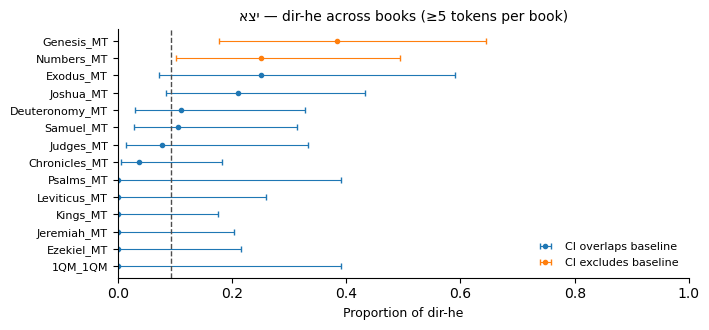

In [22]:
# -------------------- config --------------------
target_lex = "BW>["
verb_name = "bo"
construction = "dir-he"
MIN_N = 5           # minimum #tokens of this verb per book
Z = 1.96            # 95% Wilson intervals
ROW_HEIGHT = 0.20   # smaller => tighter rows

# -------------------- data prep --------------------
dfv = dfx[dfx["lex"] == target_lex].copy()
if dfv.empty:
    raise ValueError(f"No rows for lex {target_lex!r} in dfx.")

# totals per book for this verb
totals = dfv.groupby("book_scroll").size().rename("n_total")

# keep only books with ≥ MIN_N
valid_books = totals[totals >= MIN_N].index
if len(valid_books) == 0:
    raise ValueError(f"No book has ≥{MIN_N} occurrences for {target_lex!r}.")

# count "prep" per book (include zeros)
prep_counts = (
    dfv[dfv["cmpl_constr"] == construction]
    .groupby("book_scroll").size().rename("prep_count")
)

# assemble gb
gb = (
    pd.DataFrame({"n_total": totals})
    .loc[valid_books]
    .join(prep_counts, how="left")
    .fillna({"prep_count": 0})
)
gb["prep_count"] = gb["prep_count"].astype(int)
gb["p"] = gb["prep_count"] / gb["n_total"].replace(0, 1)

# global baseline for "prep" for this verb (across all books)
baseline_prep = (dfv["cmpl_constr"] == construction).mean()

# Wilson CI (score interval)
n = gb["n_total"].to_numpy(dtype=float)
p = gb["p"].to_numpy(dtype=float)
den = 1.0 + (Z**2)/n
center = (p + (Z**2)/(2*n)) / den
half = (Z * np.sqrt((p*(1-p))/n + (Z**2)/(4*n**2))) / den
lo = np.clip(center - half, 0, 1)
hi = np.clip(center + half, 0, 1)
gb["lo"], gb["hi"] = lo, hi

# order by deviation from baseline
gb["dev"] = gb["p"] - baseline_prep
gb = gb.sort_values("dev", ascending=True)

# -------------------- plotting (with significance coloring) --------------------
hebrew = lex_to_hebrew.get(target_lex, target_lex)[::-1]

fig_h = max(3.0, ROW_HEIGHT * len(gb) + 0.6)
fig, ax = plt.subplots(figsize=(7.2, fig_h))

y = np.arange(len(gb))
x = gb["p"].to_numpy()
lo = gb["lo"].to_numpy()
hi = gb["hi"].to_numpy()

# masks: "significant" if CI does NOT cross the baseline
sig_mask = (hi < baseline_prep) | (lo > baseline_prep)
nonsig_mask = ~sig_mask

def make_xerr(xvals, lo_vals, hi_vals):
    low  = np.nan_to_num(np.clip(xvals - lo_vals, 0, None), nan=0.0)
    high = np.nan_to_num(np.clip(hi_vals - xvals, 0, None), nan=0.0)
    return np.vstack([low, high])

# non-significant points (CI overlaps baseline)
xerr_ns = make_xerr(x[nonsig_mask], lo[nonsig_mask], hi[nonsig_mask])
ax.errorbar(
    x[nonsig_mask], y[nonsig_mask],
    xerr=xerr_ns,
    fmt="o", capsize=2, markersize=3, linewidth=0.8,
    label="CI overlaps baseline", color="C0", ecolor="C0"
)

# significant points (CI does NOT overlap baseline)
xerr_s = make_xerr(x[sig_mask], lo[sig_mask], hi[sig_mask])
ax.errorbar(
    x[sig_mask], y[sig_mask],
    xerr=xerr_s,
    fmt="o", capsize=2, markersize=3, linewidth=0.8,
    label="CI excludes baseline", color="C1", ecolor="C1"
)

# baseline
ax.axvline(baseline_prep, linestyle="--", linewidth=1, color="0.3")

# cosmetics: tight rows, compact labels
ax.set_yticks(y)
ax.set_yticklabels(gb.index.tolist(), fontsize=8)
ax.set_xlim(0, 1)
ax.set_xlabel(f'Proportion of {construction}', fontsize=9)

title = f'{hebrew} — {construction} across books (≥{MIN_N} tokens per book)'
ax.set_title(title, fontsize=10, pad=6)

ax.legend(loc="lower right", frameon=False, fontsize=8)

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

plt.tight_layout()

plt.savefig(f"plot_forest_{verb_name}_{construction}.png", dpi=300)

plt.show()

In [ ]:
selected_books = ["Genesis_MT", "Samuel_MT", "Psalms_MT", "Jeremiah_MT", "1QM_1QM"]
#selected_books = ["Genesis_MT", "Exodus_MT", "Deuteronomy_MT", "Leviticus_MT", "Numbers_MT"]

In [ ]:
for target_lex in lex_to_hebrew.keys():
    verb_name = re.sub(r"[^A-Za-z0-9]+", "_", target_lex)  # for filenames
    hebrew = lex_to_hebrew.get(target_lex, target_lex)[::-1]  # reversed for correct display

    # --- same data prep as your single-verb code ---
    g = (
        dfx[dfx["lex"] == target_lex]
        .groupby(["book_scroll","cmpl_constr"]).size().reset_index(name="count")
    )
    g = g[g["book_scroll"].isin(selected_books)]
    if g.empty:
        print(f"Skipping {target_lex}: no data in selected_books")
        continue

    tot = g.groupby("book_scroll")["count"].sum().rename("n_total")
    g = g.merge(tot, on="book_scroll")
    g["p"] = g["count"] / g["n_total"]

    base = (
        dfx[dfx["lex"] == target_lex]
        .groupby("cmpl_constr").size() / max(1, dfx[dfx["lex"] == target_lex].shape[0])
    )

    # Wilson CIs (same as yours)
    Z = 1.96
    p = g["p"].to_numpy()
    n = g["n_total"].to_numpy()
    den = 1 + (Z**2)/n
    center = (p + (Z**2)/(2*n)) / den
    halfwidth = (Z * np.sqrt((p*(1-p))/n + (Z**2)/(4*n**2))) / den
    g["lo"], g["hi"] = np.clip(center - halfwidth, 0, 1), np.clip(center + halfwidth, 0, 1)

    # --- plotting (unchanged structure) ---
    constructs = sorted(g["cmpl_constr"].unique())
    fig, axes = plt.subplots(1, len(constructs), figsize=(5*len(constructs), 7), sharey=True)
    if len(constructs) == 1: axes = [axes]

    for ax, c in zip(axes, constructs):
        d = g[g["cmpl_constr"] == c].set_index("book_scroll").reindex(selected_books)

        # Points with 95% CI
        ax.errorbar(
            range(len(selected_books)),
            d["p"],
            yerr=[
                np.nan_to_num(np.clip((d["p"] - d["lo"]).to_numpy(), 0, None), nan=0.0),
                np.nan_to_num(np.clip((d["hi"] - d["p"]).to_numpy(), 0, None), nan=0.0),
            ],
            fmt="o",
            capsize=3,
            label="Book estimate ±95% CI",
        )

        # Baseline (global for this verb)
        ax.axhline(base.get(c, 0.0), linestyle="--", linewidth=1, label="Verb baseline")

        # Annotate k/n above each point (clamped inside axes)
        for xi, book in enumerate(selected_books):
            if book in d.index and pd.notna(d.loc[book, "p"]):
                k = int(d.loc[book, "count"])
                n_tot = int(d.loc[book, "n_total"])
                ax.text(
                    xi,
                    min(float(d.loc[book, "hi"]) + 0.03, ax.get_ylim()[1] - 0.02),
                    f"{k}/{n_tot}",
                    ha="center", va="bottom", fontsize=8, zorder=5, clip_on=True,
                )

        ax.set_xticks(range(len(selected_books)))
        ax.set_xticklabels(selected_books, rotation=45, ha="right")
        ax.set_ylim(0, 1)
        ax.set_title(f"{hebrew} – {c}")  # Hebrew (reversed) + transliteration
        ax.set_ylabel("Proportion")
        ax.legend(loc="best", frameon=False)

    plt.tight_layout()
    # Save per verb (optional: uncomment)
    #plt.savefig(f"plot_{verb_name}_pentateuch_books.png", dpi=300, bbox_inches="tight")
    plt.show()

In [ ]:
# Counts per (verb × book), restricted to selected_books
subset_counts = (
    df_top5[df_top5["book_scroll"].isin(selected_books)]
    .groupby(["lex","book_scroll"])
    .size()
    .reset_index(name="count")
    .pivot(index="lex", columns="book_scroll", values="count")
    .fillna(0)
    .astype(int)
)

# Show the first few rows
print(subset_counts.head())

In [ ]:
# 1) Counts and within-(lex × book) proportions, EXCLUDING "prep + dir-he"
counts = (
    df_top5.loc[df_top5["cmpl_constr"].ne("prep + dir-he")]
    .dropna(subset=["cmpl_constr"])
    .groupby(["lex","book_scroll","cmpl_constr"], dropna=False)
    .size().reset_index(name="count")
)

# Guard: if after exclusion a (lex×book) has zero total, drop it before % calc
counts["total"] = counts.groupby(["lex","book_scroll"], dropna=False)["count"].transform("sum")
counts = counts[counts["total"] > 0].copy()

# Within-(lex × book) proportions (0–1)
counts["percent"] = counts["count"] / counts["total"]

# 2) Verb-level baselines (mean percent across ALL books; still excluding "prep + dir-he")
baseline = (
    counts.groupby(["lex","cmpl_constr"], dropna=False)["percent"]
          .mean()
          .reset_index(name="baseline_percent")
)

# 3) Deviations = (book share) - (verb baseline)
counts_dev = counts.merge(baseline, on=["lex","cmpl_constr"], how="left")
counts_dev["deviation"] = counts_dev["percent"] - counts_dev["baseline_percent"]

# 4) Limit to selected books ONLY for visualization
subset = counts_dev[counts_dev["book_scroll"].isin(selected_books)].copy()

In [ ]:
from scipy.stats import chi2_contingency

results = []
for lex, g in df_top5[df_top5["cmpl_constr"].ne("prep + dir-he")].groupby("lex"):
    table = pd.crosstab(g["book_scroll"], g["cmpl_constr"])
    if table.shape[0] > 1 and table.values.sum() > 0:
        chi2, p, dof, expected = chi2_contingency(table)
        results.append((lex, chi2, p))
        
verb_tests = pd.DataFrame(results, columns=["lex","chi2","pval"])

In [ ]:
verb_tests

In [ ]:
def cramers_v(chi2, n, r, c):
    return np.sqrt(chi2 / (n * (min(r-1, c-1))))

# Example (using results above):
verb_tests["cramers_v"] = [
    cramers_v(row.chi2, df_top5[df_top5["lex"]==row.lex].shape[0],
              len(df_top5[df_top5["lex"]==row.lex]["book_scroll"].unique()),
              len(df_top5[df_top5["lex"]==row.lex]["cmpl_constr"].unique()))
    for _, row in verb_tests.iterrows()
]

In [ ]:
verb_tests

In [ ]:
# CONFIG
MIN_N = 5
MAX_CI_WIDTH = 0.40  # (proportion units, i.e., 40 pp)
USE_PP = True

# 1) Aggregate & normalize (exclude "prep + dir-he")
dfx = (
    df_top5.loc[df_top5["cmpl_constr"].ne("prep + dir-he")]
    .dropna(subset=["lex","book_scroll","cmpl_constr"])
)

counts = (
    dfx.groupby(["lex","book_scroll","cmpl_constr"], dropna=False)
       .size().reset_index(name="count")
)

# totals per (lex, book)
totals = counts.groupby(["lex","book_scroll"], dropna=False)["count"].sum().rename("n_total")
counts = counts.merge(totals, on=["lex","book_scroll"], how="left")
counts = counts[counts["n_total"] > 0].copy()
counts["percent"] = counts["count"] / counts["n_total"]

# 2) Global baselines
baseline = (
    counts.groupby(["lex","cmpl_constr"], dropna=False)["percent"]
          .mean().reset_index(name="baseline")
)

# 3) Deviations
dev = counts.merge(baseline, on=["lex","cmpl_constr"], how="left")
dev["deviation"] = dev["percent"] - dev["baseline"]

# 4) Restrict to selected books
dev_sub = dev[dev["book_scroll"].isin(selected_books)].copy()

# 5) Wilson CI (95%)
Z = 1.96
p = dev_sub["percent"].to_numpy()
n = dev_sub["n_total"].to_numpy().clip(min=1)
den = 1.0 + (Z**2)/n
center = (p + (Z**2)/(2*n)) / den
halfwidth = (Z * np.sqrt((p*(1-p))/n + (Z**2)/(4*n**2))) / den
lo = np.clip(center - halfwidth, 0, 1)
hi = np.clip(center + halfwidth, 0, 1)
dev_sub["ci_width"] = hi - lo

# 6) Heatmaps, one per construction
cmpl_types = sorted(dfx["cmpl_constr"].unique().tolist())

# global symmetric color scale
all_dev = dev_sub["deviation"].to_numpy()
GLOBAL_VMAX = max(0.05, float(np.nanpercentile(np.abs(all_dev), 99)))

if USE_PP:
    dev_sub["deviation_plot"] = dev_sub["deviation"] * 100.0
    GLOBAL_VMAX_PP = GLOBAL_VMAX * 100.0
    cbar_label = "Deviation from verb baseline (pp)"
else:
    dev_sub["deviation_plot"] = dev_sub["deviation"]
    GLOBAL_VMAX_PP = GLOBAL_VMAX
    cbar_label = "Deviation from verb baseline (proportion)"

# Ensure n_mat exists in this scope
n_mat = (
    dev_sub.groupby(["lex","book_scroll"])["n_total"].first()
           .unstack("book_scroll")
           .reindex(columns=selected_books)
)

# import re  # <-- Only needed if you keep saving with sanitized filenames.

for constr in cmpl_types:
    sub = dev_sub[dev_sub["cmpl_constr"] == constr]

    mat = (
        sub.pivot(index="lex", columns="book_scroll", values="deviation_plot")
           .reindex(columns=selected_books)
           .reindex(index=n_mat.index)
    )
    ciw = (
        sub.pivot(index="lex", columns="book_scroll", values="ci_width")
           .reindex(columns=selected_books).reindex(index=mat.index)
    )
    n_here = n_mat.reindex(index=mat.index)

    # NEW: per-cell count for THIS construction (k)
    n_constr_mat = (
        sub.pivot(index="lex", columns="book_scroll", values="count")
           .reindex(columns=selected_books).reindex(index=mat.index)
           .fillna(0).astype(int)
    )

    # mask: low n OR too-wide CI  (simplified)
    mask = (n_here < MIN_N) | (ciw > MAX_CI_WIDTH)

    plt.figure(figsize=(8, max(6, 0.25*len(n_mat.index)+3)))
    ax = sns.heatmap(
        mat, mask=mask,
        cmap="RdBu_r", vmin=-GLOBAL_VMAX_PP, vmax=GLOBAL_VMAX_PP, center=0,
        cbar_kws={"label": cbar_label},
        linewidths=0.5, linecolor="white", annot=False
    )

    # annotate k/n
    for i, lex in enumerate(mat.index):
        for j, book in enumerate(mat.columns):
            if pd.notna(n_here.loc[lex, book]) and not mask.loc[lex, book]:
                k = int(n_constr_mat.loc[lex, book]) if pd.notna(n_constr_mat.loc[lex, book]) else 0
                n_ = int(n_here.loc[lex, book])
                ax.text(j + 0.5, i + 0.5, f"{k}/{n_}", ha="center", va="center", fontsize=7, color="black")

    ax.set_title(f"{constr} (masked: n<{MIN_N} or CI width>{int(MAX_CI_WIDTH*100)}pp)")
    ax.set_xlabel("Book / Scroll")
    ax.set_ylabel("Verb (lex)")
    # Force right-to-left rendering
    ax.set_yticklabels([lex_to_hebrew.get(lex, lex)[::-1] for lex in mat.index], rotation=0)
    
    plt.tight_layout()

    # Saving: pick ONE of the following:
    safe_constr = re.sub(r"[^A-Za-z0-9]+", "_", constr)
    filename = f"heatmap_{safe_constr}_pentateuch_books.png"
    #plt.savefig(filename, dpi=300, bbox_inches="tight")

    plt.show()
    # If not saving, remove the print below to avoid confusion:
    # print(f"Saved: {filename}")

In [ ]:
# ----------------- Config -----------------
row_height   = 2.0      # inches per verb row
col_width    = 4.5      # inches per construction column
marker_size  = 4
capsize      = 3
alpha_points = 0.9
alpha_grid   = 0.15
baseline_lw  = 1.0
baseline_alpha = 0.8
show_counts  = True     # annotate k/n above each point
# Optionally: show CI only when n_total >= threshold (set to None to disable)
ci_min_n     = None     # e.g., 10

# ----------------- Prep -----------------
# keep only verbs / constructs that actually appear (optional but helps avoid fully empty columns/rows)
verbs      = sorted(res["lex"].unique())
constructs = sorted(res["cmpl_constr"].unique())

# Build a fast lookup table (book order alignment)
book_indexer = pd.Index(selected_books)

# ----------------- Figure & layout -----------------
fig = plt.figure(
    figsize=(col_width * max(1, len(constructs)), row_height * max(1, len(verbs))),
    constrained_layout=True  # <-- preferred over tight_layout for nested grids
)
outer = gridspec.GridSpec(nrows=1, ncols=max(1, len(constructs)), figure=fig, wspace=0.15)

for j, c in enumerate(constructs):
    # sub-grid: rows = verbs, one column
    subgs = outer[j].subgridspec(nrows=max(1, len(verbs)), ncols=1, hspace=0.05)

    for i, lex in enumerate(verbs):
        ax = fig.add_subplot(subgs[i, 0])

        # Align to all selected books; this may introduce NaNs (expected)
        sub = (
            res[(res["lex"] == lex) & (res["cmpl_constr"] == c)]
            .set_index("book_scroll")
            .reindex(book_indexer)
        )

        # Plot points + CI if any data present
        if "p" in sub and sub["p"].notna().any():
            y = sub["p"].to_numpy()

            # Optionally suppress CI for low n
            if ci_min_n is not None and "n_total" in sub:
                mask_hi_n = (sub["n_total"] >= ci_min_n).fillna(False).to_numpy()
            else:
                mask_hi_n = np.ones(len(sub), dtype=bool)

            # Non-negative, NaN-safe yerr
            yerr_low_full  = np.nan_to_num(np.clip((sub["p"] - sub["lo"]).to_numpy(), 0, None), nan=0.0)
            yerr_high_full = np.nan_to_num(np.clip((sub["hi"] - sub["p"]).to_numpy(), 0, None), nan=0.0)

            # Apply mask if using ci_min_n
            yerr = [yerr_low_full.copy(), yerr_high_full.copy()]
            if ci_min_n is not None:
                yerr[0][~mask_hi_n] = 0.0
                yerr[1][~mask_hi_n] = 0.0

            ax.errorbar(
                x=range(len(selected_books)), y=y,
                yerr=yerr,
                fmt="o", capsize=capsize, markersize=marker_size,
                color="black", alpha=alpha_points
            )

            if show_counts and "count" in sub and "n_total" in sub:
                # annotate k/n above points (clamped to top of panel)
                for xi, book in enumerate(selected_books):
                    if book in sub.index and pd.notna(sub.at[book, "p"]):
                        k = int(sub.at[book, "count"])   if pd.notna(sub.at[book, "count"])   else 0
                        n = int(sub.at[book, "n_total"]) if pd.notna(sub.at[book, "n_total"]) else 0
                        hi = sub.at[book, "hi"] if pd.notna(sub.at[book, "hi"]) else sub.at[book, "p"]
                        hi = float(hi) if pd.notna(hi) else float(sub.at[book, "p"])
                        ax.text(
                            xi, min(hi + 0.03, 0.98),
                            f"{k}/{n}",
                            ha="center", va="bottom", fontsize=7, clip_on=True
                        )

        # Baseline for this verb+construction
        base_val = baseline_map.get((lex, c), None)
        if base_val is not None:
            ax.axhline(base_val, linestyle="--", color="red", lw=baseline_lw, alpha=baseline_alpha)

        # Cosmetics & labels
        ax.set_ylim(0, 1)
        ax.grid(axis="y", alpha=alpha_grid)
        ax.set_xticks(range(len(selected_books)))

        # X tick labels only on bottom row of this column
        if i == len(verbs) - 1:
            ax.set_xticklabels(selected_books, rotation=45, ha="right")
        else:
            ax.set_xticklabels([])

        # Left-side label for each mini-panel: the verb (Hebrew reversed for display)
        hebrew = lex_to_hebrew.get(lex, lex)[::-1]
        ax.set_ylabel(hebrew, rotation=0, labelpad=18, va="center")

        # Column title on the top row
        if i == 0:
            ax.set_title(f"Construction: {c}")

# add the legend
dot = mlines.Line2D([], [], color="black", marker="o", linestyle="None",
                    markersize=marker_size, label="Proportion ±95% CI")
baseline_line = mlines.Line2D([], [], color="red", linestyle="--", lw=baseline_lw,
                              alpha=baseline_alpha, label="Verb baseline")


fig.legend(handles=[dot, baseline_line],
           loc="lower center", bbox_to_anchor=(0.5, -0.02),
           ncol=2, frameon=False, fontsize=9)

plt.savefig(
    "small_multiples_constructions_selected.png",   # filename
    dpi=300,                               # resolution
    bbox_inches="tight"                    # trims whitespace
)

plt.show()